### Imports

In [26]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from tqdm import tqdm
import pickle
from nltk.corpus import stopwords
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import f1_score

from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

### Loading datasets

In [10]:
df_sample_submission = pd.read_csv('datasets/sample_submission.csv')
df_test = pd.read_csv('datasets/test.csv')
df_train = pd.read_csv('datasets/train.csv')

In [11]:
pd.set_option('max_colwidth',200)

### Preprocessing

In [12]:
display(df_sample_submission.sample(3))
display(df_test.sample(3))
display(df_train.sample(3))

,id,target
305,1000,0
1996,6728,0
2858,9476,0


,id,keyword,location,text
858,2812,cyclone,NYC,@orochinagicom GIGATECH CYCLONE
1286,4228,drowned,NaN,Jeff was bullied Sally was raped Ben was drowned Hoodie was betrayed LJ was abandoned EJ was a sacrifice Lost S.. (http://t.co/mFl7jzspOu)
42,140,accident,NaN,@Calum5SOS this happened on accident but I like it http://t.co/QHmXuljSX9


,id,keyword,location,text,target
5615,8012,refugees,"Aurora, Ontario",Turkish newlyweds donate wedding money - what a beautiful gesture! Still have faith in humanity. http://t.co/o1eNHjrkJd,0
1281,1847,burned,Chicago,I spent 15 minutes lifting weights. 43 calories burned. #LoseIt,0
2160,3100,deaths,Top Secret,As of 2010 there were 17 Beluga deaths reported at #SeaWorld their average age 15 1/2 years #OpSeaWorld http://t.co/MZk5UjlFCV,1


<AxesSubplot:xlabel='target', ylabel='count'>

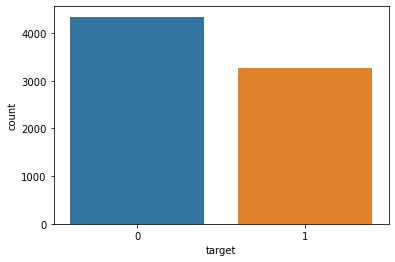

In [39]:
sns.countplot(x = df_train["target"], data = df_train)

Можно начать с самой простой модели

In [8]:
df_train.isnull().mean()

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [17]:
df_sample_submission.columns

Index(['id', 'target'], dtype='object')

In [18]:
df_sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [21]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/UtbXLcBIuY
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3


In [16]:
df_test.columns

Index(['id', 'keyword', 'location', 'text'], dtype='object')

In [22]:
df_sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [20]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1


In [11]:
print(df_sample_submission.shape)
print(df_train.shape)
print(df_test.shape)

(3263, 2)
(7613, 5)
(3263, 4)


In [23]:
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [25]:
df_train.loc[lambda x:x['target'] == 1]['text']

0                                                                           Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1                                                                                                          Forest fire near La Ronge Sask. Canada
2           All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3                                                                               13,000 people receive #wildfires evacuation orders in California 
4                                                        Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
                                                                          ...                                                                    
7608                                                          Two giant cranes holding a bridge collapse into nearby homes h

### Натренируем некоторые модели популярные

In [19]:
corpus = df_train['text'].values

In [20]:
#Lemmatization function
def lemmatization(texts):
    nlp = spacy.load("en_core_web_sm")
    texts_out = []
    for text in tqdm(texts):
        doc = nlp(text)
        new_text = []
        for token in doc:
            new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

In [25]:
print(corpus[0:10])
lemmatized_texts=lemmatization(corpus)
print(corpus[0:10])

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 '13,000 people receive #wildfires evacuation orders in California '
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas'
 "I'm on top of the hill and I can see a fire in the woods..."
 "There's an emergency evacuation happening now in the building across the street"
 "I'm afraid that the tornado is coming to our area..."]


100%|██████████████████████████████████████████████████████████████████████████████| 7613/7613 [04:28<00:00, 28.31it/s]

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 '13,000 people receive #wildfires evacuation orders in California '
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas'
 "I'm on top of the hill and I can see a fire in the woods..."
 "There's an emergency evacuation happening now in the building across the street"
 "I'm afraid that the tornado is coming to our area..."]


In [28]:
#Сериализуем лемматизированные тексты чтобы не возвращаться к этому
# with open("lemmatized_texts.pkl", "wb") as f:
#     pickle.dump(lemmatized_texts, f)

In [41]:
##Загрузим сериализованные датасеты
with open("lemmatized_texts.pkl", "rb") as f:
    lemmatized_texts = pickle.load(f)

In [7]:
def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Z ]', ' ', text).split())

In [8]:
stop_words = set(stopwords.words('english'))
preprocessed_corpus=[]
for i in tqdm(range(len(lemmatized_texts))):
    preprocessed_corpus.append((clear_text(str.lower(lemmatized_texts[i]))))

100%|██████████████████████████████████████████████████████████████████████████| 7613/7613 [00:00<00:00, 195576.79it/s]


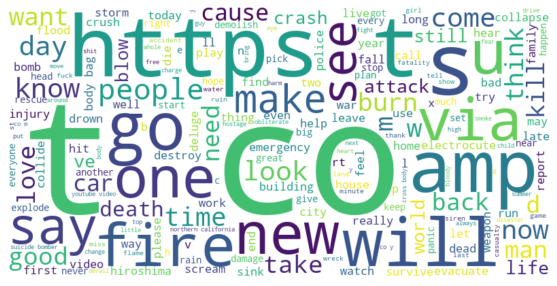

In [9]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(preprocessed_corpus))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Следует основательно почистить текста. Для этого посмотрим слова,биграммы,триграммы

#### Отдельные слова

In [11]:
count_vect = CountVectorizer(stop_words=stop_words) 
bow = count_vect.fit_transform(preprocessed_corpus) 

print("Размер мешка без учёта стоп-слов:", bow.shape)

Размер мешка без учёта стоп-слов: (7613, 20335)


In [14]:
word_list=count_vect.get_feature_names() 
count_list = bow.sum(axis=0).A1

In [15]:
x = dict(zip(word_list,count_list))
g={k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)}
result_series = pd.Series(g)

In [16]:
result_series[0:20]

co        4741
http      4309
https      412
like       394
get        361
fire       358
amp        344
go         287
new        230
via        220
news       212
one        209
people     201
say        199
would      185
see        183
year       177
make       176
video      175
kill       172
dtype: int64

#### Биграммы

In [17]:
count_vect = CountVectorizer(ngram_range=(2, 2),stop_words=stop_words) 
bow = count_vect.fit_transform(preprocessed_corpus) 

print("Размер мешка без учёта стоп-слов:", bow.shape)

Размер мешка без учёта стоп-слов: (7613, 55380)


In [18]:
word_list=count_vect.get_feature_names() 
count_list = bow.sum(axis=0).A1


In [19]:
x = dict(zip(word_list,count_list))
{k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)}
g={k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)}
result_series = pd.Series(g)

In [20]:
result_series[0:20]

http co                4306
https co                411
body bag                 62
suicide bomber           60
look like                55
burn building            52
video http               44
youtube video            43
like youtube             42
northern california      41
cross body               40
oil spill                39
california wildfire      35
year old                 35
suicide bombing          34
mass murder              33
news http                32
bomber detonate          31
feel like                31
fire http                31
dtype: int64

#### Триграммы

In [21]:
count_vect = CountVectorizer(ngram_range=(3, 3),stop_words=stop_words) 
bow = count_vect.fit_transform(preprocessed_corpus) 

print("Размер мешка без учёта стоп-слов:", bow.shape)

Размер мешка без учёта стоп-слов: (7613, 57270)


In [22]:
word_list=count_vect.get_feature_names() 
count_list = bow.sum(axis=0).A1

In [23]:
x = dict(zip(word_list,count_list))
{k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)}
g={k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)}
result_series = pd.Series(g)

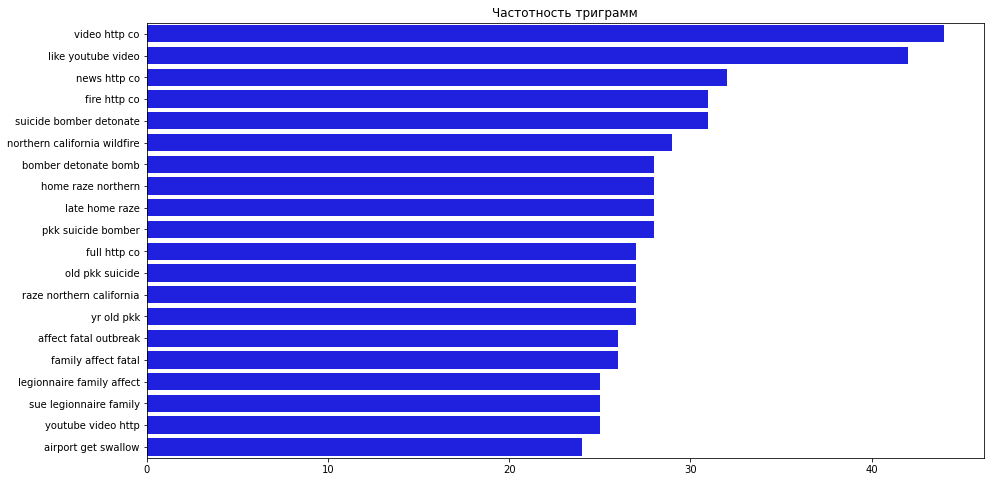

In [24]:
plt.figure(figsize=(15,8))
sns.barplot(y=result_series[0:20].index, x=result_series[0:20].values,color='blue')
plt.title("Частотность триграмм")
plt.show()

In [28]:
features = preprocessed_corpus
target = df_train['target']
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state = 12345, test_size=0.2)

In [29]:
count_tf_idf = TfidfVectorizer() 
tf_idf = count_tf_idf.fit_transform(features_train) 
tf_idf2 = count_tf_idf.transform(features_test)

In [30]:
print(np.array(features).shape)
print(df_train.shape)

(7613,)
(7613, 5)


#### Логистическая регрессия

In [31]:
parameters = {'C':range(1,10,1)}

log_regr_rand=RandomizedSearchCV(LogisticRegression(class_weight='balanced',penalty='l2'), parameters, cv=5, random_state=12345,scoring='f1')
log_regr_rand.fit(tf_idf, target_train)
print('Лучшие параметры: ',log_regr_rand.best_params_)
log_regression_model=log_regr_rand.best_estimator_



C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшие параметры:  {'C': 5}


In [32]:
prediction = log_regression_model.predict(tf_idf2)
log_regression_result=f1_score(target_test, prediction)
print('F1 score for logistic regression',log_regression_result)

F1 score for logistic regression 0.7679640718562875


Сравним лог регрессию с CountVectorizer

In [59]:
print(tf_idf.shape)
print(tf_idf2.shape)

(6090, 17569)
(1523, 17569)


In [61]:
print(tf_idf)

  (0, 2945)	0.22389352597080114
  (0, 7124)	0.3761616689421772
  (0, 15169)	0.2914837504652961
  (0, 13047)	0.3251747198787395
  (0, 7301)	0.2900102831825312
  (0, 12592)	0.2945789185692838
  (0, 10704)	0.151487795790554
  (0, 5015)	0.2571215456993024
  (0, 3342)	0.2808291269159946
  (0, 9363)	0.5280766695620315
  (1, 10938)	0.4176341614099245
  (1, 2580)	0.07630854243297772
  (1, 6672)	0.08055249680568376
  (1, 1044)	0.33098167206898005
  (1, 1570)	0.22809215055310245
  (1, 12992)	0.32136929525628155
  (1, 16232)	0.24039251061286368
  (1, 2263)	0.39886371579765034
  (1, 11168)	0.30878050052510175
  (1, 10569)	0.11715510500691138
  (1, 7157)	0.39886371579765034
  (1, 15732)	0.2517401153138524
  (2, 16816)	0.2519809483496342
  (2, 4452)	0.2326203735471526
  (2, 7677)	0.2519809483496342
  :	:
  (6088, 10707)	0.19442484100921031
  (6088, 10328)	0.14141495205191007
  (6088, 1193)	0.08726906428304015
  (6088, 14774)	0.09035660028398479
  (6088, 2580)	0.06926391210451219
  (6088, 6672)	0.073

In [55]:
vectorizer = CountVectorizer()
print(np.array(features_train).shape)
count_matrix_train = vectorizer.fit_transform(features_train)
print(count_matrix_train.shape)
count_array_train = count_matrix_train.toarray()
print(count_array_train.shape)

print(np.array(features_test).shape)
count_matrix_test = vectorizer.fit_transform(features_test)
print(count_matrix_test.shape)
count_array_test = count_matrix_test.toarray()
print(count_array_test.shape)

(6090,)
(6090, 17569)
(6090, 17569)
(1523,)
(1523, 6604)
(1523, 6604)


In [34]:
#Этот код выполнялся оченьо долго остановил
parameters = {'C':range(1,10,1)}

log_regr_rand=RandomizedSearchCV(LogisticRegression(class_weight='balanced',penalty='l2'), parameters, cv=5, random_state=12345,scoring='f1')
log_regr_rand.fit(count_array_train, target_train)
print('Лучшие параметры: ',log_regr_rand.best_params_)
log_regression_model=log_regr_rand.best_estimator_

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data a

Лучшие параметры:  {'C': 1}


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
log_regr_rand.best_score_

0.7501725594761964

In [48]:
print(np.array(features_test).shape)
print(count_matrix_train.shape)
print(tf_idf.shape)

print(count_matrix_test.shape)
print(tf_idf2.shape)

(1523,)
(6090, 17569)
(6090, 17569)
(1523, 6604)
(1523, 17569)


In [63]:
#На TF IDF Обучение идет быстрей

In [57]:
prediction = log_regression_model.predict(tf_idf2)
log_regression_result=f1_score(target_test, prediction)
print('F1 score for logistic regression',log_regression_result)

F1 score for logistic regression 0.2777777777777778


#### Градиентный бустинг

In [64]:
parameters = {"num_leaves": range(2, 110, 10), "n_estimators": range(50, 500, 50)}
LGBM_search = RandomizedSearchCV(
    LGBMClassifier(class_weight="balanced", importance_type="gain"),
    parameters,
    cv=5,
    random_state=12345,
    scoring="f1",
    n_jobs=-1,
)

LGBM_search.fit(tf_idf, target_train)

model_lgbm_class = LGBM_search.best_estimator_
predictions_lgbm = model_lgbm_class.predict(tf_idf2)

print("LGBM Classifier f1_score: ", f1_score(target_test, predictions_lgbm))

In [65]:
LGBM_search.fit(tf_idf, target_train)


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight='balanced',
                                            importance_type='gain'),
                   n_jobs=-1,
                   param_distributions={'n_estimators': range(50, 500, 50),
                                        'num_leaves': range(2, 110, 10)},
                   random_state=12345, scoring='f1')

In [66]:
model_lgbm_class = LGBM_search.best_estimator_
predictions_lgbm = model_lgbm_class.predict(tf_idf2)

print("LGBM Classifier f1_score: ", f1_score(target_test, predictions_lgbm))

LGBM Classifier f1_score:  0.7478260869565218


In [75]:
LGBM_class=LGBMClassifier(num_leaves=30,n_estimators=361)
LGBM_class.fit(tf_idf, target_train)
predictions = LGBM_class.predict(tf_idf2)
print(f1_score(target_test, predictions))

0.7296416938110748


Почему то результат хуже регрессии

#### Functions for cleaning up the text

In [3]:
#This function accepts a string and uses regular expressions
#to remove URLs from the string, before returning the cleaned string.
def remove_URL(text):
  url = re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r'',text)

In [4]:
#This function accepts a string and uses regular expressions
#to remove HTML tags from the string, before returning the cleaned string.
def remove_html(text):
  html=re.compile(r'<.*?>')
  return html.sub(r'',text)

In [6]:
remove_URL('Website Malfunctioning? PHP Scripts not working? Database Crashed? Need a Unique Script? PHP PRO to the rescue! http://t.co/LadH9Oo086')

'Website Malfunctioning? PHP Scripts not working? Database Crashed? Need a Unique Script? PHP PRO to the rescue! '

In [8]:
#This function accepts a string and uses regular expressions
#to remove Twitter mentions from the string, before returning the cleaned string.
def remove_mentions(text):
  return re.sub("@[A-Za-z0-9]+","",text)

In [7]:
#This function accepts a string and uses regular expressions
#to remove emojis from the string, before returning the cleaned string.

# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
  emoji_pattern = re.compile("["
  u"\U0001F600-\U0001F64F"  # Emoticons
  u"\U0001F300-\U0001F5FF"  # Symbols & Pictographs
  u"\U0001F680-\U0001F6FF"  # Transport & Map symbols
  u"\U0001F1E0-\U0001F1FF"  # IOS Flags
  u"\U00002500-\U00002BEF"  # Chinese characters
  u"\U00002702-\U000027B0"
  u"\U00002702-\U000027B0"
  u"\U000024C2-\U0001F251"
  u"\U0001f926-\U0001f937"
  u"\U00010000-\U0010ffff"
  u"\u2640-\u2642"
  u"\u2600-\u2B55"
  u"\u200d"
  u"\u23cf"
  u"\u23e9"
  u"\u231a"
  u"\ufe0f"  # Dingbats
  u"\u3030"
  "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)

In [15]:
#This function accepts a string and uses regular expressions
#to remove Twitter mentions from the string, before returning the cleaned string.
def remove_mentions(text):
  return re.sub("@[A-Za-z0-9]+","",text)

In [24]:
#This function will be used to process text to
#create a bag-of-words model.
def text_processor(messy_str):
  """
  Accepts a messy string, cleans it, 
  and then returns the string as list.

  1. Removes URLs and make the string lowercase.
  2. Removes HTML tags.
  3. Removes popular emoji symbols.
  4. Remove Twitter mentions.
  5. Remove punctionation.
  7. Remove numbers.
  8. Remove stopwords.
  9. Return list of cleaned, lowercase words
  """
  
  #Remove URLs from the string
  cln_str = remove_URL(messy_str).lower()

  #Remove HTML tags from the string
  cln_str = remove_html(cln_str)

  #Remove emoji from the string
  cln_str = remove_emoji(cln_str)

    

  #Remove Twitter mentions from the string
  cln_str = remove_mentions(cln_str)

  #Removes the punctuation from the string
  nopunc = [char for char in cln_str if char not in string.punctuation]
  nopunc = ''.join(nopunc)

  #Removes digits from the string
  nonum = [char for char in nopunc if char not in string.digits]
  nonum = ''.join(nonum)

  #Remove the stopwords and return a cleaned list of words
  return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [ ]:
#Lemmatization function
def lemmatization(texts):
    nlp = spacy.load("en_core_web_sm")
    texts_out = []
    for text in tqdm(texts):
        doc = nlp(text)
        new_text = []
        for token in doc:
            new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

In [47]:
text_processor(lemmatized_texts[66])

['time', 'talk', 'go', 'know', 'make', 'due', 'work']

In [48]:
text_processor(str(df_train['text'][66]))

['time', 'talk', 'go', 'dont', 'know', 'make', 'due', 'work']

In [49]:
#Create the features, X, and the target, y,
#and then split them into training and validation sets.
X, y = df_train['text'], df_train['target']
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.20,random_state=12345)
#The validation set will be 20% of the training data, as set by the test_size parameter

In [53]:
#Create the features, X, and the target, y,
#and then split them into training and validation sets.
X, y = lemmatized_texts, df_train['target']
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.20,random_state=12345)
#The validation set will be 20% of the training data, as set by the test_size parameter

In [54]:
count_tf_idf = TfidfVectorizer(analyzer=text_processor) 
tf_idf = count_tf_idf.fit_transform(X_train) 
tf_idf2 = count_tf_idf.transform(X_val)

In [55]:
parameters = {'C':range(1,10,1)}

log_regr_rand=RandomizedSearchCV(LogisticRegression(class_weight='balanced',penalty='l2'), parameters, cv=5, random_state=12345,scoring='f1')
log_regr_rand.fit(tf_idf, y_train)
print('Лучшие параметры: ',log_regr_rand.best_params_)
print(' f1 score at training : ',log_regr_rand.best_score_)
log_regression_model=log_regr_rand.best_estimator_

prediction = log_regression_model.predict(tf_idf2)
log_regression_result=f1_score(y_val, prediction)
print('F1 score for logistic regression',log_regression_result)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшие параметры:  {'C': 2}
 f1 score at training :  0.7433561927681802
F1 score for logistic regression 0.7619783616692427


### Сделаем тоже с лемматизацией 

In [ ]:
Лемматизаций ухудшает параметры 

In [56]:
parameters = {"num_leaves": range(2, 110, 10), "n_estimators": range(50, 500, 50)}
LGBM_search = RandomizedSearchCV(
    LGBMClassifier(class_weight="balanced", importance_type="gain"),
    parameters,
    cv=5,
    random_state=12345,
    scoring="f1",
    n_jobs=-1,
)

LGBM_search.fit(tf_idf, y_train)

model_lgbm_class = LGBM_search.best_estimator_
predictions_lgbm = model_lgbm_class.predict(tf_idf2)

print("LGBM Classifier f1_score: ", f1_score(y_val, predictions_lgbm))

LGBM Classifier f1_score:  0.7279874213836478


### Теперь добавим к df_train df_test

In [60]:
df_train.sample()

,id,keyword,location,text,target
2129,3057,deaths,"Palermo, Sicily",Silence. #Palermo #Shipwreck #Children #Deaths http://t.co/Tm9ZBHJcyf,1


In [61]:
df_test['target']=np.nan

In [67]:
df_full=pd.concat([df_train,df_test])
df_full=df_full.reset_index()

In [72]:
df_train.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d,1


In [70]:
df_test.head(3)

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,NaN
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.",NaN
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",NaN


In [76]:
df_full[lambda x:x.index>7612].shape

(3263, 6)

In [ ]:
df_full.loc[lambda x:x[]]

In [66]:
df_test.head(3)

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,NaN
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.",NaN
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",NaN


#### Submit

Version 1

In [79]:
#Create the features, X, and the target, y,
#and then split them into training and validation sets.
X, y = df_full['text'], df_full['target']
X_train, X_val, = X.loc[lambda x:x.index<=7612],X.loc[lambda x:x.index>7612]
y_train, y_val = y.loc[lambda x:x.index<=7612],y.loc[lambda x:x.index>7612]
#The validation set will be 20% of the training data, as set by the test_size parameter

In [80]:
count_tf_idf = TfidfVectorizer(analyzer=text_processor) 
tf_idf = count_tf_idf.fit_transform(X_train) 
tf_idf2 = count_tf_idf.transform(X_val)

In [104]:
tf_idf.shape

(7613, 15973)

In [81]:
parameters = {'C':range(1,10,1)}

log_regr_rand=RandomizedSearchCV(LogisticRegression(class_weight='balanced',penalty='l2'), parameters, cv=5, random_state=12345,scoring='f1')
log_regr_rand.fit(tf_idf, y_train)
print('Лучшие параметры: ',log_regr_rand.best_params_)
print(' f1 score at training : ',log_regr_rand.best_score_)
log_regression_model=log_regr_rand.best_estimator_

prediction = log_regression_model.predict(tf_idf2)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшие параметры:  {'C': 1}
 f1 score at training :  0.6262299474529132


In [87]:
parameters = {"num_leaves": range(2, 110, 10), "n_estimators": range(50, 500, 50)}
LGBM_search = RandomizedSearchCV(
    LGBMClassifier(class_weight="balanced", importance_type="gain"),
    parameters,
    cv=5,
    random_state=12345,
    scoring="f1",
    n_jobs=-1,
)

LGBM_search.fit(tf_idf, y_train)

model_lgbm_class = LGBM_search.best_estimator_
print('f1 score LGBM ',LGBM_search.best_score_)
predictions_lgbm = model_lgbm_class.predict(tf_idf2)

f1 score LGBM  0.5515361378178807


In [90]:
df_test['target']=prediction

In [92]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        3263 non-null   int64  
 1   keyword   3237 non-null   object 
 2   location  2158 non-null   object 
 3   text      3263 non-null   object 
 4   target    3263 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 127.6+ KB


In [93]:
df_sample_submission = df_test[['id','target']]

In [98]:
df_sample_submission['target']=df_sample_submission['target'].astype('int64')

<ipython-input-98-b84211c378a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample_submission['target']=df_sample_submission['target'].astype('int64')


In [99]:
df_sample_submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [101]:
df_sample_submission.to_csv('df_sample_sub.csv',index=False)

Text(0.5, 1.0, 'Keyword number')

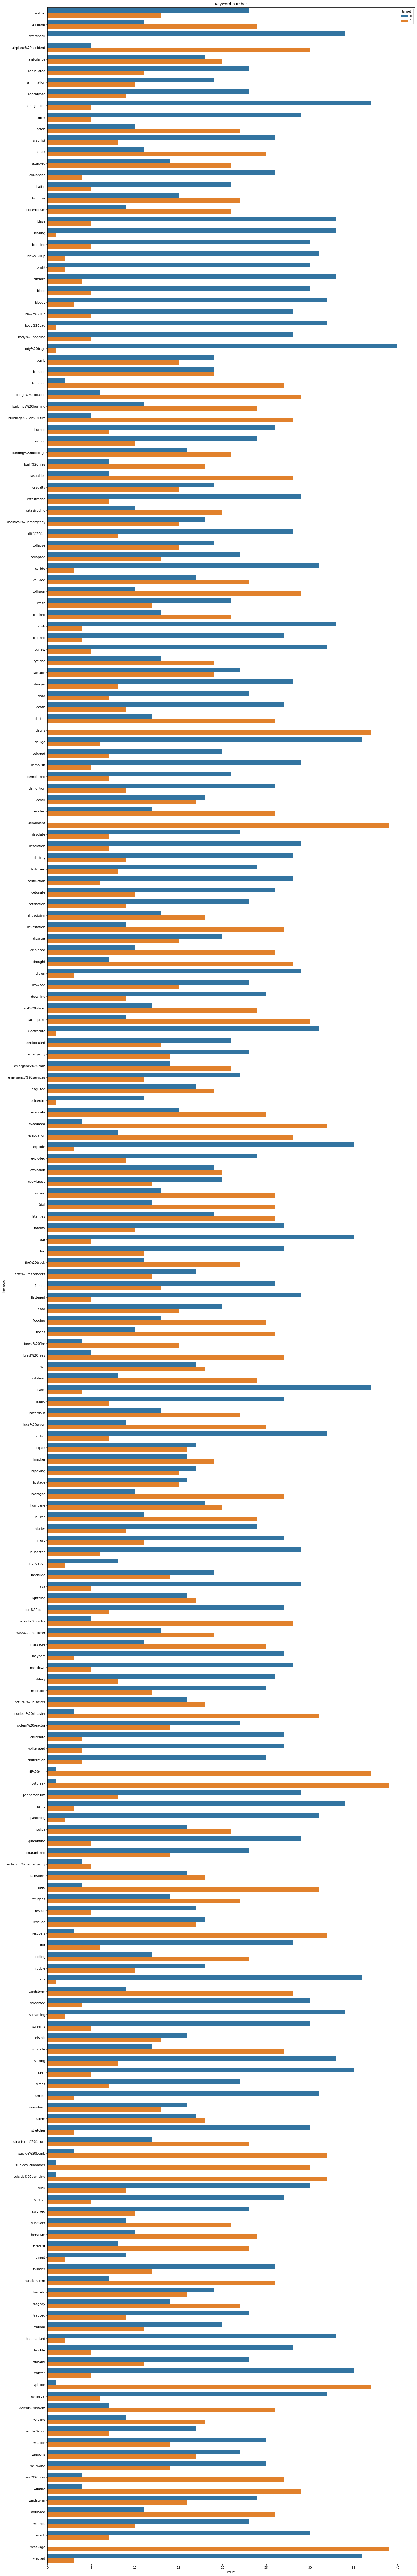

In [103]:
plt.figure(figsize=(21,150))
sns.countplot(data=df_train, y='keyword', hue='target')
plt.title('Keyword number')

Version 2

In [106]:
#Create the features, X, and the target, y,
#and then split them into training and validation sets.
X, y = df_full['text'], df_full['target']
count_tf_idf = TfidfVectorizer(analyzer=text_processor) 
tf_idf = count_tf_idf.fit_transform(X) 


In [114]:
tf_idf.get_shape()

(10876, 19800)

In [111]:
tf_idf[lambda x:x.index<=7612]

IndexError: Index dimension must be <= 2

In [105]:

X_train, X_val, = X.loc[lambda x:x.index<=7612],X.loc[lambda x:x.index>7612]
y_train, y_val = y.loc[lambda x:x.index<=7612],y.loc[lambda x:x.index>7612]
#The validation set will be 20% of the training data, as set by the test_size parameter

Попробуем обучить 

###  Выводы

1. https://habr.com/ru/post/580560/  Ссылка про word_cloud
2. Нужно ли убирать http co и прочие похожие на мусорные слова неизвестно. Попробуем научить модель с ними и без них и посмотрим на метрики
